In [1]:
import os
import pathlib

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import PIL.Image
import seaborn as sns

# import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score

random_state = 42

%matplotlib inline

In [2]:
# For Google Colab Only
# Mount GDrive
from google.colab import drive

drive.mount("/content/drive")

# For Google Colab Only
# Put Colab in the context of this challenge

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir("/content/drive/MyDrive/Colab Notebooks/EmoSense/notebooks")

Mounted at /content/drive


In [ ]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "raw_data_rafdb_all_in_one")
cache_path = pathlib.Path(cwd, "..", "cache")

# Reading in the images from all the folders and putting them together in one DF
# TODO: Save the output to a single folder
df = pd.DataFrame(columns=["filename", "label"])
i = 0
label_dict = {}
with os.scandir(data_path) as entries:
    for entry in entries:
        entry_path = os.path.join(data_path, entry)
        if os.path.isdir(entry_path):
            filelist = [f.name for f in os.scandir(entry_path)]
            df = pd.concat(
                [df, pd.DataFrame({"filename": filelist, "label": entry.name})]
            )
            label_dict[entry.name] = i
        i += 1

df.reset_index(inplace=True, drop=True)
# df.describe()

# int-encoding and then one-hot encoding the labels...
df["label_int"] = df.label.apply(lambda x: label_dict[x])
n_classes = len(label_dict)
y = tf.keras.utils.to_categorical(df.label_int, n_classes)

# replace the filename column with the full path to each file
df["filepath"] = df.apply(
    lambda x: os.path.join(data_path, x["label"], x["filename"]), axis=1
)
df.drop(columns="filename", inplace=True)

X = df.filepath

# Note: In Python 3.7+ dictionaries are ordered.
class_names = list(label_dict.keys())
label_dict

{'surprise': 0,
 'fear': 1,
 'disgust': 2,
 'happiness': 3,
 'anger': 4,
 'sadness': 5,
 'neutral': 6}

In [ ]:
BATCH_SIZE = 32

# Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
try:
    AUTOTUNE = tf.data.AUTOTUNE
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

def preprocess(images, labels):
    # return tf.keras.applications.vgg16.preprocess_input(images), labels
    return tf.keras.applications.densenet.preprocess_input(images), labels

ds_train, ds_val_test = tf.keras.utils.image_dataset_from_directory(
    directory=data_path,
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    shuffle=True,
    seed=random_state,
    validation_split=0.2,
    subset="both",
)
ds_train = ds_train.map(preprocess)
ds_val_test = ds_val_test.map(preprocess)

val_test_batches = tf.data.experimental.cardinality(ds_val_test)
ds_val = ds_val_test.take(val_test_batches // 2)
ds_test = ds_val_test.skip(val_test_batches // 2)

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

Found 15339 files belonging to 7 classes.
Using 12272 files for training.
Using 3067 files for validation.


In [ ]:
def get_pretrained_model(n_fine_tune = 0):
    # model_pretrained = tf.keras.applications.vgg16.VGG16(
    model_pretrained = tf.keras.applications.densenet.DenseNet121(
        include_top=False, input_shape=(224, 224, 3)
    )
    # model_pretrained.trainable = False

    if n_fine_tune > 0:
        for layer in model_pretrained.layers[:-n_fine_tune]:
            layer.trainable = False
    elif n_fine_tune == -1:
            model_pretrained.trainable = True
    else:
        for layer in model_pretrained.layers:
            layer.trainable = False

    return model_pretrained

# pretrained = get_pretrained_model()
# pretrained.summary()

In [ ]:
LR = 1e-4

def get_compiled_custom_model(num_classes, n_fine_tune = 0):
    base_model = get_pretrained_model(n_fine_tune)

    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(
        256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.003)
    ))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

model = get_compiled_custom_model(num_classes=n_classes, n_fine_tune=-1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               25690624  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 7)                

In [ ]:
N_EPOCHS = 100

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, min_delta=.0001, patience=3, verbose=1, min_lr=1e-8)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="auto",
    min_delta=.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True,
)
history = model.fit(
    ds_train, epochs=N_EPOCHS, validation_data=ds_val, verbose=1, callbacks=[lr_reducer, es]
)

Epoch 1/100
384/384 [==============================] - 92s 102ms/step - loss: 7.1582 - accuracy: 0.4131 - val_loss: 4.9521 - val_accuracy: 0.5951 - lr: 1.0000e-04
Epoch 2/100
384/384 [==============================] - 37s 96ms/step - loss: 4.1577 - accuracy: 0.5808 - val_loss: 3.2682 - val_accuracy: 0.6738 - lr: 1.0000e-04
Epoch 3/100
384/384 [==============================] - 37s 96ms/step - loss: 2.8517 - accuracy: 0.6844 - val_loss: 2.3301 - val_accuracy: 0.7487 - lr: 1.0000e-04
Epoch 4/100
384/384 [==============================] - 37s 96ms/step - loss: 2.0347 - accuracy: 0.7551 - val_loss: 1.7597 - val_accuracy: 0.7715 - lr: 1.0000e-04
Epoch 5/100
384/384 [==============================] - 37s 96ms/step - loss: 1.5337 - accuracy: 0.7956 - val_loss: 1.4818 - val_accuracy: 0.7715 - lr: 1.0000e-04
Epoch 6/100
384/384 [==============================] - 37s 95ms/step - loss: 1.1804 - accuracy: 0.8374 - val_loss: 1.2890 - val_accuracy: 0.7715 - lr: 1.0000e-04
Epoch 7/100
384/384 [======

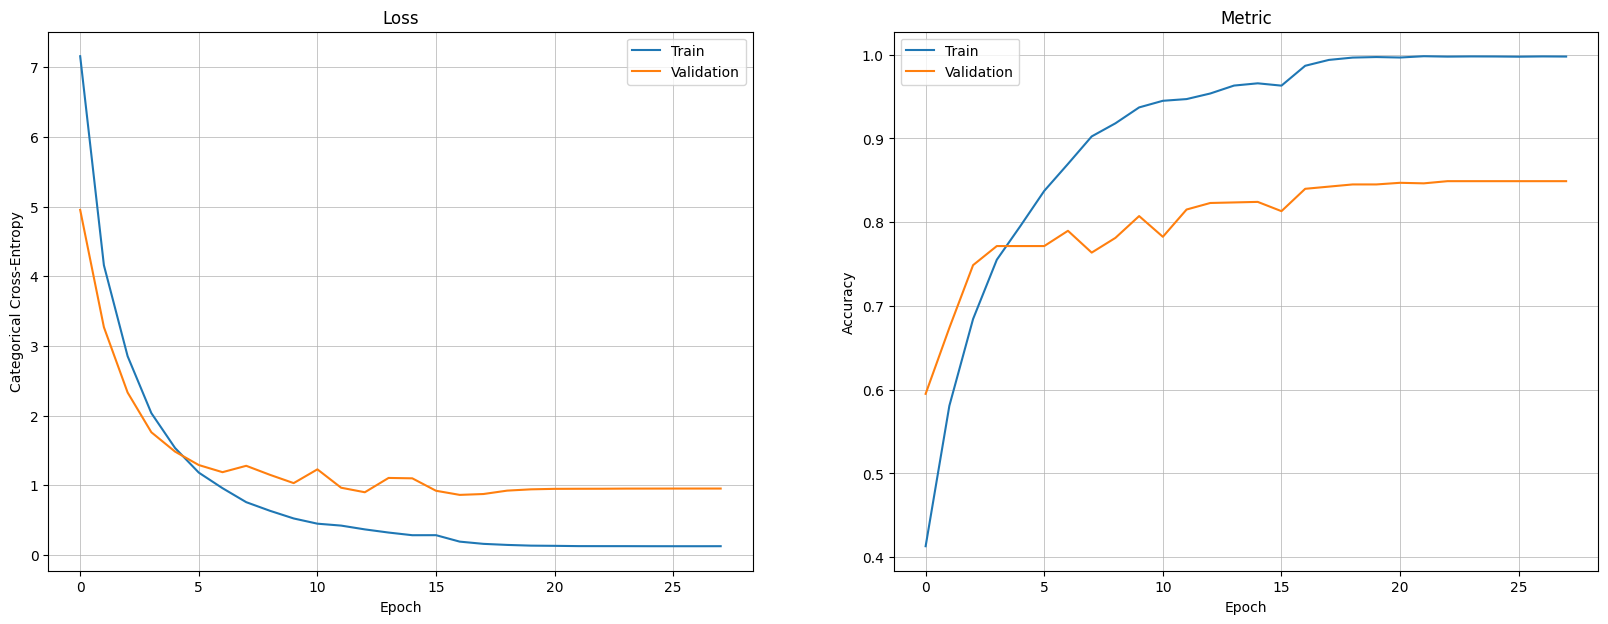

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Categorical Cross-Entropy ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Categorical Cross-Entropy")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Accuracy ---

    ax[1].plot(history.history["accuracy"])
    ax[1].plot(history.history["val_accuracy"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

plot_history(history);

In [ ]:
# model.save("model.h5")
model.save('model.keras')
pickle.dump(history, open("model_history.pkl", "wb"))

In [ ]:
# tf.data.Dataset.save(ds_test, "ds_test")

In [3]:
# # To load a saved model:
# loaded_model = tf.keras.models.load_model(
#     "model.keras",
#     compile=True,
# )

In [ ]:
res = model.evaluate(ds_test, return_dict=True)
res

48/48 [==============================] - 1s 29ms/step - loss: 1.0798 - accuracy: 0.8256


{'loss': 1.0797890424728394, 'accuracy': 0.8256042003631592}

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in ds_test:  # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    #    y_pred.append(preds)
    #    y_pred.append((preds > 0.5))
    y_pred.append((preds > 0.5) * 1)

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)

print(classification_report(correct_labels, predicted_labels, target_names=label_dict.keys()))

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

    surprise       0.84      0.83      0.84       155
        fear       0.72      0.54      0.62        39
     disgust       0.56      0.41      0.48        82
   happiness       0.93      0.94      0.94       631
       anger       0.80      0.72      0.76        82
     sadness       0.79      0.71      0.75       241
     neutral       0.74      0.85      0.79       301

   micro avg       0.83      0.82      0.83      1531
   macro avg       0.77      0.71      0.74      1531
weighted avg       0.83      0.82      0.83      1531
 samples avg       0.82      0.82      0.82      1531



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
